In [ ]:
import pandas as pd

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test.head(20)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [193]:
df_train.shape
df_train.info()
df_train.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Problems 
- Age column: a lot of missing values
- Ticket column: Different ticket numbers (number, letters or num+letters), many missing data
- Sex column: male/female can be represented as 0/1 
- Cabin column: 687 NaN values 
- Fare column: inconsistancy in Fare column (float numbers), some passengers paid 0.00, some 512.0
- Embarked column: 2 missing values

## How many passengers from each city  

In [194]:
df_train.count_passengers = df_train['Embarked'].value_counts()
df_train.count_passengers

C:\Users\46739\AppData\Local\Temp\ipykernel_22188\368863076.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_train.count_passengers = df_train['Embarked'].value_counts()


Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

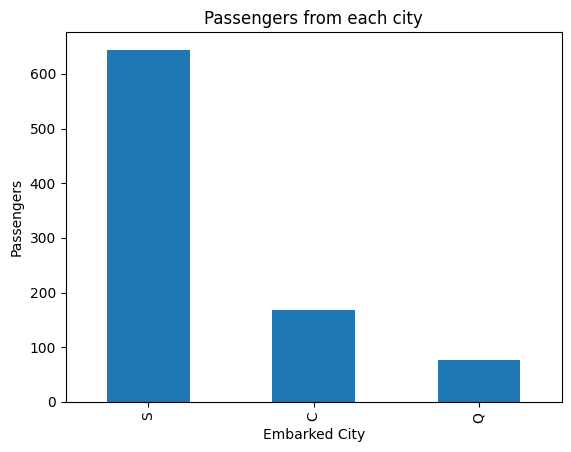

In [195]:
import matplotlib.pyplot as plt

df_train.count_passengers.plot(kind='bar', title='Passengers from each city')
plt.xlabel('Embarked City')
plt.ylabel('Passengers')
plt.show()


In [196]:
df_train['Embarked'].value_counts(dropna=False)


Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

### Handling with data in Embarked column 
- 2 missing values (I have decided to fill in missing values with the most common value to keep only 3 types of values (because small amount of missing data compared to the dataset))

In [197]:
most_common = df_train['Embarked'].mode()[0]
df_train['Embarked'].fillna(most_common, inplace=True)
df_train['Embarked'].value_counts(dropna=False)

C:\Users\46739\AppData\Local\Temp\ipykernel_22188\2068968131.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Embarked'].fillna(most_common, inplace=True)


Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

- do the same for the df_test data

In [198]:
most_common = df_test['Embarked'].mode()[0]
df_test['Embarked'].fillna(most_common, inplace=True)
df_test['Embarked'].value_counts(dropna=False)

C:\Users\46739\AppData\Local\Temp\ipykernel_22188\2636559882.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Embarked'].fillna(most_common, inplace=True)


Embarked
S    270
C    102
Q     46
Name: count, dtype: int64

### Handling with data in Cabin column 
- Many missing values but probably useful info about the deck (if I try to keep this little data it will not be beneficial for the model to learn from this data) so I will keep info "has Cabin" or "not" in binary 0/1 
- I create a new column "hasCabin" and put new data there to save the raw data in some case
- Extract Deck letter into new column + Unknown (for raws with missing data) 

In [199]:
df_train['hasCabin'] = df_train['Cabin'].notna().astype(int)
df_train['Deck'] = df_train['Cabin'].str[0].fillna('Unknown')
df_train[['hasCabin', 'Deck']].head(7)

,hasCabin,Deck
0,0,Unknown
1,1,C
2,0,Unknown
3,1,C
4,0,Unknown
5,0,Unknown
6,1,E


In [200]:
df_test['hasCabin'] = df_test['Cabin'].notna().astype(int)
df_test['Deck'] = df_test['Cabin'].str[0].fillna('Unknown')
df_test[['hasCabin', 'Deck']].head(20)

,hasCabin,Deck
0,0,Unknown
1,0,Unknown
2,0,Unknown
3,0,Unknown
4,0,Unknown
5,0,Unknown
6,0,Unknown
7,0,Unknown
8,0,Unknown
9,0,Unknown


### Handling with data in Sex column 
- I will convert categorical values male/female to numerical format for the better performance from the model 

In [201]:
def encode_sex(s): 
	if s == 'male': 
		return 0 
	elif s == 'female': 
		return 1 
df_train['Sex'] = df_train['Sex'].apply(encode_sex)
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hasCabin,Deck
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,C
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,Unknown
5,6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,NaN,Q,0,Unknown
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,1,E
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S,0,Unknown
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S,0,Unknown
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C,0,Unknown


In [202]:
def encode_sex(s): 
	if s == 'male': 
		return 0 
	elif s == 'female': 
		return 1 
df_test['Sex'] = df_test['Sex'].apply(encode_sex)
df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hasCabin,Deck
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,Unknown
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,Unknown
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,Unknown
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,Unknown
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,0,Unknown
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,0,0,7538,9.2250,NaN,S,0,Unknown
6,898,3,"Connolly, Miss. Kate",1,30.0,0,0,330972,7.6292,NaN,Q,0,Unknown
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,1,1,248738,29.0000,NaN,S,0,Unknown
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,18.0,0,0,2657,7.2292,NaN,C,0,Unknown
9,901,3,"Davies, Mr. John Samuel",0,21.0,2,0,A/4 48871,24.1500,NaN,S,0,Unknown


### Handling data in Name column 
- Extract title (Mr, Mrs, Miss etc) which show us age, gender and social status 


In [203]:
df_train['Title'] = df_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_train.head(10)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\46739\AppData\Local\Temp\ipykernel_22188\1785137082.py:1: SyntaxWarning: invalid escape sequence '\.'
  df_train['Title'] = df_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hasCabin,Deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Unknown,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Unknown,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,Unknown,Mr
5,6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,NaN,Q,0,Unknown,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,1,E,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S,0,Unknown,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S,0,Unknown,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C,0,Unknown,Mrs


In [204]:
df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_test.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\46739\AppData\Local\Temp\ipykernel_22188\4125807813.py:1: SyntaxWarning: invalid escape sequence '\.'
  df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hasCabin,Deck,Title
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,Unknown,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,Unknown,Mrs
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,Unknown,Mr
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,Unknown,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,0,Unknown,Mrs


### Handling data in Age column 
- Many missing values (177) 
- I will check the title for the person with missing age and fill in the age with median for the particular title 
- Creare age categories: child 0-17, adult 18-59, senior 60-100

In [205]:
df_train['Age'] = df_train.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
df_train['Age'].value_counts(dropna=False)

Age
30.00    144
21.00     60
35.00     35
24.00     30
22.00     27
        ... 
24.50      1
46.50      1
0.42       1
34.50      1
74.00      1
Name: count, Length: 90, dtype: int64

In [206]:
df_test['Age'] = df_test.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
df_test['Age'].value_counts(dropna=False)

c:\Users\46739\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Age
28.5    58
22.0    30
21.0    17
24.0    17
30.0    15
        ..
44.0     1
5.0      1
51.0     1
3.0      1
38.5     1
Name: count, Length: 80, dtype: int64

In [149]:
def apply_ageCategory(age):
	if age >= 0 and age <= 17:
		return 'Child'
	elif age >= 18 and age <= 59:
		return 'Adult'
	else:
		return 'Senior'


df['Age_category'] = df['Age'].apply(apply_ageCategory)
df['Age_category'].value_counts(dropna=False)

Age_category
Adult     748
Child     117
Senior     26
Name: count, dtype: int64

In [150]:
df.head(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hasCabin,Deck,Title,Age_category
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Unknown,Mr,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,C,Mrs,Adult
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Unknown,Miss,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,C,Mrs,Adult
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,Unknown,Mr,Adult
5,6,0,3,"Moran, Mr. James",0,30.0,0,0,330877,8.4583,NaN,Q,0,Unknown,Mr,Adult
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,1,E,Mr,Adult


### Handling with Ticket column 
- check how many people has same ticket numbers
- check if they have same last name (probably they are from one family)
- drop the column because of too much missing data and incon
 

In [152]:
df['Ticket'].value_counts(dropna=False)

Ticket
347082             7
1601               7
CA. 2343           7
3101295            6
CA 2144            6
                  ..
SOTON/OQ 392076    1
211536             1
112053             1
111369             1
392091             1
Name: count, Length: 681, dtype: int64

In [ ]:
df[df['Ticket'] == '347082'][['Name', 'Ticket', 'Fare']]


,Name,Ticket,Fare
13,"Andersson, Mr. Anders Johan",347082,31.275
119,"Andersson, Miss. Ellis Anna Maria",347082,31.275
541,"Andersson, Miss. Ingeborg Constanzia",347082,31.275
542,"Andersson, Miss. Sigrid Elisabeth",347082,31.275
610,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",347082,31.275
813,"Andersson, Miss. Ebba Iris Alfrida",347082,31.275
850,"Andersson, Master. Sigvard Harald Elias",347082,31.275


In [162]:
df = df.drop(columns=['Ticket'])

### Create FamilySize feature  

In [163]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['FamilySize'].head(10)
df['FamilySize'].value_counts(dropna=False)

FamilySize
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64

In [165]:
df[df['FamilySize'] == 11][['Name', 'Fare']]

,Name,Fare
159,"Sage, Master. Thomas Henry",69.55
180,"Sage, Miss. Constance Gladys",69.55
201,"Sage, Mr. Frederick",69.55
324,"Sage, Mr. George John Jr",69.55
792,"Sage, Miss. Stella Anna",69.55
846,"Sage, Mr. Douglas Bullen",69.55
863,"Sage, Miss. Dorothy Edith ""Dolly""",69.55


### Handling data in Fare column 
- Some duplicated tickets
- Range from 0 to 512 


In [168]:
df['Fare'].isnull().sum()



np.int64(0)